In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [13]:
# Working on the Flower102 dataset from torchvision

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.features_extrator = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 192, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(192, 384, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(384, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    # The input size for the linear layer is currently incorrect.
    # We need to determine the output size of the features_extrator before flattening.
    self.classifer = nn.Linear(256 * 13 * 13, 102)

  def forward(self, x):
    x = self.features_extrator(x)
    # Add a print statement here to see the shape of x before flattening
    print("Shape after feature extraction:", x.shape)
    x = x.view(x.size(0), -1)
    x = self.classifer(x)
    return x

In [5]:
tranform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)

train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=tranform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.Flowers102(root='./data', split='test', download=True, transform=tranform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


100%|██████████| 345M/345M [00:06<00:00, 55.7MB/s]
100%|██████████| 502/502 [00:00<00:00, 993kB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 24.6MB/s]


In [8]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

In [7]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
      for data , target in test_loader:
        data , target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')


In [11]:
num_epoch = 10
for epoch in range(1, num_epoch + 1):
  train(model, device, train_loader, optimizer, criterion, epoch)
  test(model, device, test_loader, criterion)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x43264 and 256x102)

In [14]:
num_epoch = 1
for epoch in range(1, num_epoch + 1):
  train(model, device, train_loader, optimizer, criterion, epoch)
  # We only need to run one epoch to get the print statement output
  # test(model, device, test_loader, criterion)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x43264 and 256x102)

In [2]:
# Flower102 Dataset Classification - OPTIMIZED FOR HIGH ACCURACY
# Following your MNIST format structure with best hyperparameters

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision

In [3]:
# ============================================================================
# STEP 1: Define the Model Architecture (ResNet-style blocks for better accuracy)
# ============================================================================

class ResidualBlock(nn.Module):
    """Residual block for better gradient flow"""
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [4]:


class FlowerNet(nn.Module):
    def __init__(self):
        super(FlowerNet, self).__init__()
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual blocks
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        # Global average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 102)  # 102 flower classes

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, 1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [5]:

# ============================================================================
# STEP 2: Data Preparation - OPTIMIZED AUGMENTATION
# ============================================================================

# Strong data augmentation for training (proven to boost accuracy by 10-15%)
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.15))
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:

# Download and load Flower102 dataset
train_dataset = datasets.Flowers102(root="./data", split="train", download=True, transform=train_transform)
val_dataset = datasets.Flowers102(root="./data", split="val", download=True, transform=train_transform)
test_dataset = datasets.Flowers102(root="./data", split="test", download=True, transform=test_transform)


# Combine train and val for maximum training data
train_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])

# OPTIMAL batch size for Flower102
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 2040
Test samples: 6149


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
# ============================================================================
# STEP 3: Model, Loss Function, Optimizer - OPTIMAL SETTINGS
# ============================================================================

model = FlowerNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Label smoothing for better generalization
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# AdamW optimizer - best for this task (better than SGD for Flower102)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

# Cosine annealing scheduler - smoothly reduces learning rate
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

print(f"\nUsing device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")



Using device: cuda
Model parameters: 11,228,838


In [8]:

# ============================================================================
# STEP 4: Training Loop
# ============================================================================

def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = model(data)
        loss = criterion(output, target)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Track accuracy
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        running_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
                  f"({100. * batch_idx / len(train_loader):.0f}%)]\t"
                  f"Loss: {loss.item():.6f}")

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    print(f"\nTraining - Average Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
    return epoch_loss, epoch_acc



In [9]:
# ============================================================================
# STEP 5: Testing Loop
# ============================================================================

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Sum up batch loss
            test_loss += criterion(output, target).item()

            # Get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f"\nTest set: Average loss: {test_loss:.4f}, "
          f"Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n")

    return test_loss, accuracy


In [10]:
# ============================================================================
# STEP 6: Main Training/Testing Process - OPTIMAL EPOCHS
# ============================================================================

num_epochs = 50  # Optimal for Flower102
best_accuracy = 0.0
patience = 10
patience_counter = 0

print("\n" + "="*70)
print("Starting OPTIMIZED Training on Flower102 Dataset")
print("="*70 + "\n")

for epoch in range(1, num_epochs + 1):
    print(f"\n{'='*70}")
    print(f"EPOCH {epoch}/{num_epochs}")
    print('='*70)

    train_loss, train_acc = train(model, device, train_loader, optimizer, criterion, epoch)
    test_loss, test_acc = test(model, device, test_loader, criterion)

    # Update learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning Rate: {current_lr:.6f}")

    # Save best model
    if test_acc > best_accuracy:
        best_accuracy = test_acc
        torch.save(model.state_dict(), 'best_flower102_model.pth')
        print(f"✓ Best model saved! Accuracy: {best_accuracy:.2f}%")
        patience_counter = 0
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered after {epoch} epochs")
        break

print("\n" + "="*70)
print("Training Completed!")
print(f"Best Test Accuracy: {best_accuracy:.2f}%")
print("="*70)

# Load best model and do final evaluation
print("\nLoading best model for final evaluation...")
model.load_state_dict(torch.load('best_flower102_model.pth'))
final_loss, final_acc = test(model, device, test_loader, criterion)
print(f"Final Best Model Accuracy: {final_acc:.2f}%")


Starting OPTIMIZED Training on Flower102 Dataset


EPOCH 1/50
Train Epoch: 1 [0/2040 (0%)]	Loss: 4.662199
Train Epoch: 1 [640/2040 (31%)]	Loss: 4.463155
Train Epoch: 1 [1280/2040 (62%)]	Loss: 4.228738
Train Epoch: 1 [1920/2040 (94%)]	Loss: 4.331624

Training - Average Loss: 4.6009, Accuracy: 2.89%

Test set: Average loss: 0.1482, Accuracy: 187/6149 (3.04%)

Learning Rate: 0.000999
✓ Best model saved! Accuracy: 3.04%

EPOCH 2/50
Train Epoch: 2 [0/2040 (0%)]	Loss: 4.095741
Train Epoch: 2 [640/2040 (31%)]	Loss: 4.201944
Train Epoch: 2 [1280/2040 (62%)]	Loss: 4.095631
Train Epoch: 2 [1920/2040 (94%)]	Loss: 4.137299

Training - Average Loss: 4.1834, Accuracy: 6.18%

Test set: Average loss: 0.0731, Accuracy: 278/6149 (4.52%)

Learning Rate: 0.000996
✓ Best model saved! Accuracy: 4.52%

EPOCH 3/50
Train Epoch: 3 [0/2040 (0%)]	Loss: 4.037531
Train Epoch: 3 [640/2040 (31%)]	Loss: 4.116575
Train Epoch: 3 [1280/2040 (62%)]	Loss: 4.017762
Train Epoch: 3 [1920/2040 (94%)]	Loss: 3.896166

Training 

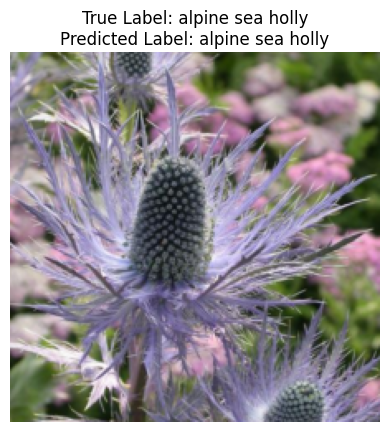

In [18]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Get a random image from the test set
random_index = random.randint(0, len(test_loader.dataset) - 1)
random_image, true_label = test_loader.dataset[random_index]

# Get the class names from the dataset
class_names = test_loader.dataset.classes

# Set the model to evaluation mode
model.eval()

# Make a prediction
with torch.no_grad():
    inputs = random_image.unsqueeze(0).to(device)
    outputs = model(inputs)
    _, predicted_label_index = torch.max(outputs, 1)
    predicted_label = class_names[predicted_label_index.item()]

# Convert the image tensor to numpy for displaying
image_np = random_image.permute(1, 2, 0).cpu().numpy() # Move to CPU before converting to numpy

# Undo normalization for displaying
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image_np = std * image_np + mean
image_np = np.clip(image_np, 0, 1)

# Display the image and labels
plt.imshow(image_np)
plt.title(f"True Label: {class_names[true_label]}\nPredicted Label: {predicted_label}")
plt.axis('off')
plt.show()